#  Install Dependencies and Setup

In [19]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\91768\AppData\Local\Temp\pip-install-ckt_1255\tensorflow-gpu_f457c40a7ba8415da286fc18329a4bef\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not buil

In [20]:
!pip list

Package                      Version
---------------------------- ----------
absl-py                      1.4.0
appdirs                      1.4.4
asgiref                      3.6.0
asttokens                    2.4.1
astunparse                   1.6.3
attrs                        23.1.0
beautifulsoup4               4.12.2
blinker                      1.7.0
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.15.1
charset-normalizer           3.3.2
click                        8.1.7
cmake                        3.25.2
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.1.0
customtkinter                0.3
cycler                       0.11.0
darkdetect                   0.8.0
debugpy                      1.8.0
decorator                    5.1.1
Django                       4.1.7
exceptiongroup               1.2.0
executing                    2.0.1
Flask                        3.0.0
flatb

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
os.listdir(data_dir)

['dwv virus', 'hb']

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 154 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

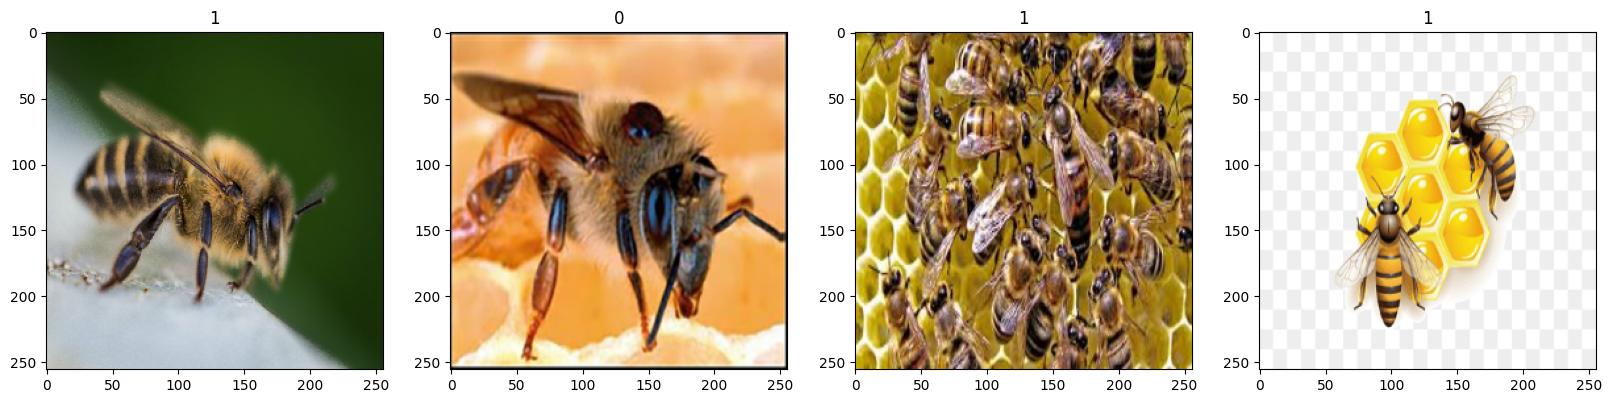

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#  Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[9.42373201e-02, 4.76236977e-02, 2.72719432e-02],
          [6.45680130e-02, 4.73441323e-03, 0.00000000e+00],
          [6.74220696e-02, 7.37304706e-03, 6.02213526e-03],
          ...,
          [9.96750534e-01, 7.94754326e-01, 4.43949133e-01],
          [9.94012356e-01, 8.04978549e-01, 4.70846742e-01],
          [9.99866903e-01, 8.21155012e-01, 4.87821698e-01]],
 
         [[1.63907394e-01, 3.98131125e-02, 0.00000000e+00],
          [1.20874502e-01, 1.50218289e-02, 2.43202355e-02],
          [7.87607208e-02, 1.33798635e-02, 1.83957573e-02],
          ...,
          [9.91856217e-01, 7.83093035e-01, 4.34543490e-01],
          [9.94433582e-01, 8.00977528e-01, 4.59081084e-01],
          [9.99845862e-01, 8.06986272e-01, 4.79641557e-01]],
 
         [[4.34524357e-01, 2.69986987e-01, 1.13525391e-01],
          [1.41817942e-01, 8.61768518e-03, 0.00000000e+00],
          [9.40831825e-02, 1.05660232e-02, 6.49988512e-03],
          ...,
          [9.94154036e-01, 7.72092342e-01, 4.2811

#  Split Data

In [17]:
len(data)

5

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [19]:
train_size+val_size+test_size

5

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [21]:
len(test)

1

#  Build Deep Learning Model

In [22]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

#  Train

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


3/3 [==============================] - 6s 950ms/step - loss: 2.0348 - accuracy: 0.4896 - val_loss: 1.4807 - val_accuracy: 0.3750
Epoch 2/20
3/3 [==============================] - 3s 798ms/step - loss: 1.1095 - accuracy: 0.4062 - val_loss: 0.7055 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 3s 808ms/step - loss: 0.6513 - accuracy: 0.6354 - val_loss: 0.7117 - val_accuracy: 0.5625
Epoch 4/20
3/3 [==============================] - 3s 787ms/step - loss: 0.6629 - accuracy: 0.5729 - val_loss: 0.6187 - val_accuracy: 0.7188
Epoch 5/20
3/3 [==============================] - 3s 852ms/step - loss: 0.6555 - accuracy: 0.5938 - val_loss: 0.6572 - val_accuracy: 0.5312
Epoch 6/20
3/3 [==============================] - 3s 896ms/step - loss: 0.6091 - accuracy: 0.6771 - val_loss: 0.5995 - val_accuracy: 0.5625
Epoch 7/20
3/3 [==============================] - 3s 763ms/step - loss: 0.5761 - accuracy: 0.6146 - val_loss: 0.5702 - val_accuracy: 0.6875
Epoch 8/20
3/3 [==

#  Plot Performance

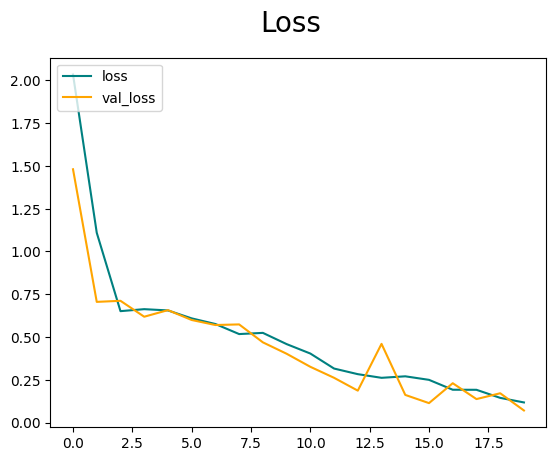

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

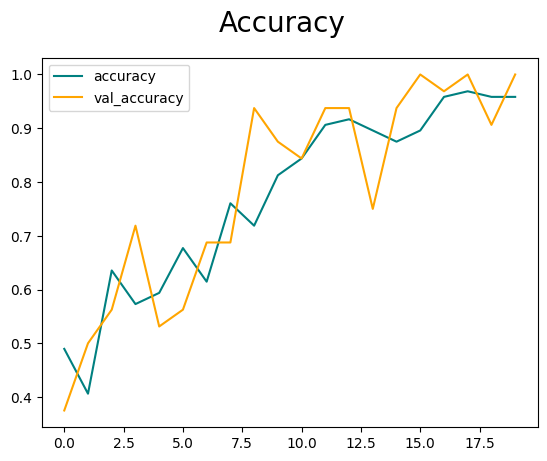

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [35]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 268ms/step


In [36]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


#  Test

In [37]:
import cv2

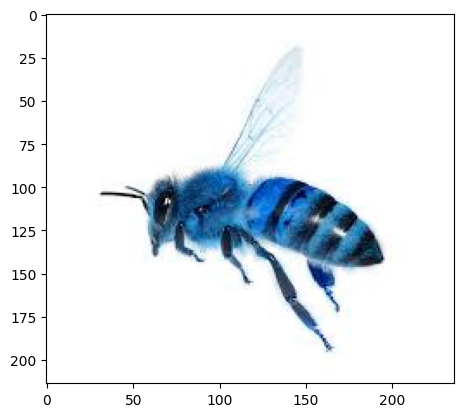

In [44]:
img = cv2.imread('heltest.jpeg')
plt.imshow(img)
plt.show()

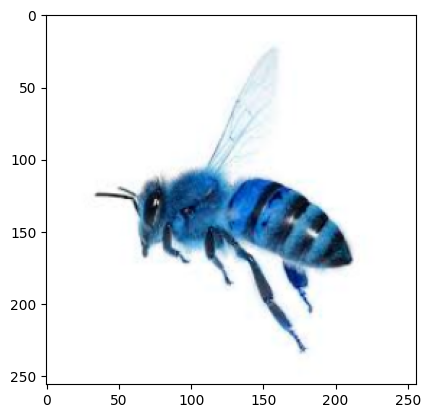

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
resize.shape

TensorShape([256, 256, 3])

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 37ms/step


In [48]:
yhat

array([[0.98312205]], dtype=float32)

In [49]:
if yhat > 0.9: 
    print(f'Predicted class is healthy')
else:
    print(f'Predicted class is infected')

Predicted class is healthy


 # Save the Model
 

In [50]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models','keras_model.h5'))

c:\Users\91768\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
